In [3]:
# needed to import dataset from google drive into colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd gdrive

/content/gdrive


In [4]:
cd MyDrive

/content/gdrive/MyDrive


In [5]:
import os
import cv2
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
import joblib

In [6]:
# Constants
IMAGE_SIZE = (224, 224)


In [7]:
# Function to preprocess and extract HOG features from an image
def preprocess_and_extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image in color
    image = cv2.resize(image, IMAGE_SIZE)  # Resize to desired size
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

In [8]:
# Function to generate segmentation mask (simple threshold-based approach)
def generate_segmentation_mask(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, IMAGE_SIZE)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a binary mask for skin color
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    return skin_mask

In [9]:
# Load and preprocess the dataset, including segmentation mask generation
dataset_path = "cancer-full-dataset"
data = []
labels = []
masks = []  # Store segmentation masks

class_names = ["benign", "malignant"]

for class_idx, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        features = preprocess_and_extract_features(image_path)
        segmentation_mask = generate_segmentation_mask(image_path)
        data.append(features)
        labels.append(class_idx)
        masks.append(segmentation_mask)

In [10]:
# Split the dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp, masks_train, masks_temp = train_test_split(data, labels, masks, test_size=0.2, random_state=123)
X_val, X_test, y_val, y_test, masks_val, masks_test = train_test_split(X_temp, y_temp, masks_temp, test_size=0.5, random_state=123)


In [11]:
# Initialize lists to store training and validation accuracy values
train_accuracy_values = []
val_accuracy_values = []

In [12]:
# Train an SVM classifier
svm_classifier = svm.SVC(kernel='linear', C=1.0, probability=True)  # Note: probability=True for ROC curve

In [13]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    svm_classifier.fit(X_train, y_train)

    # Evaluate the SVM classifier on the training set
    train_accuracy = svm_classifier.score(X_train, y_train)

    # Evaluate the SVM classifier on the validation set
    val_accuracy = svm_classifier.score(X_val, y_val)

    # Append accuracy values to the lists
    train_accuracy_values.append(train_accuracy)
    val_accuracy_values.append(val_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Accuracy: {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [2/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [3/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [4/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [5/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [6/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [7/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [8/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [9/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036
Epoch [10/10] - Train Accuracy: 1.0000 - Validation Accuracy: 0.9036


In [14]:
# Evaluate the SVM classifier on the test set
test_accuracy = svm_classifier.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.868020304568528


In [15]:
# Evaluate the SVM classifier on the test set
train_accuracy = svm_classifier.score(X_train, y_train)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 1.0


In [16]:
# Calculate precision, recall, and F1-score on the test set
y_pred = svm_classifier.predict(X_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


In [17]:
# Print precision, recall, and F1-score
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Precision: 0.8670378254462093
Recall: 0.868020304568528
F1-Score: 0.8617143249122945


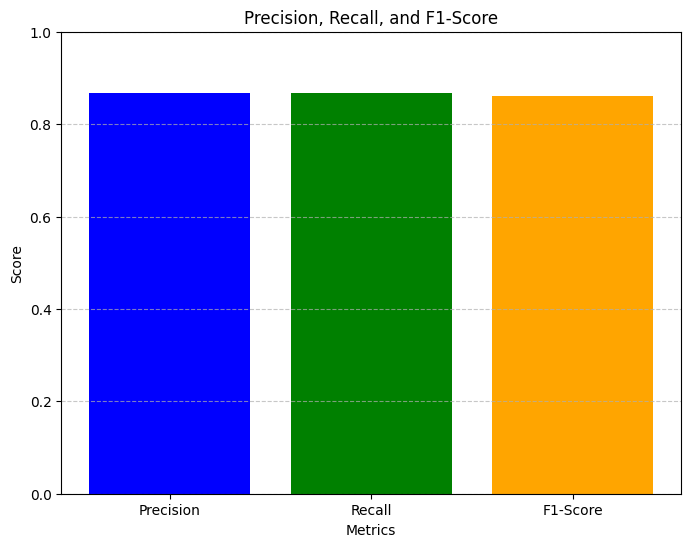

In [18]:
# Plot precision, recall, and F1-score
plt.figure(figsize=(8, 6))
metrics = ["Precision", "Recall", "F1-Score"]
scores = [precision, recall, f1]

plt.bar(metrics, scores, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1-Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

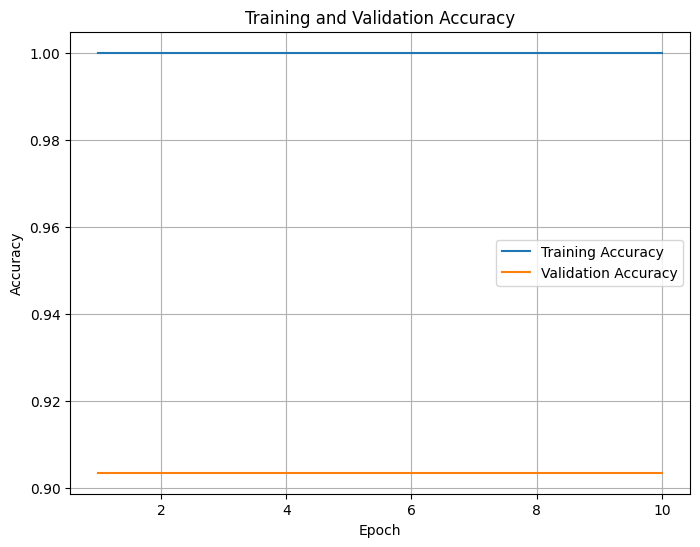

In [19]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
epochs = range(1, num_epochs+1)
plt.plot(epochs, train_accuracy_values, label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Calculate ROC curve and AUC
y_scores = svm_classifier.predict_proba(X_test)[:, 1]  # Probability of being in class '1' (malignant)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

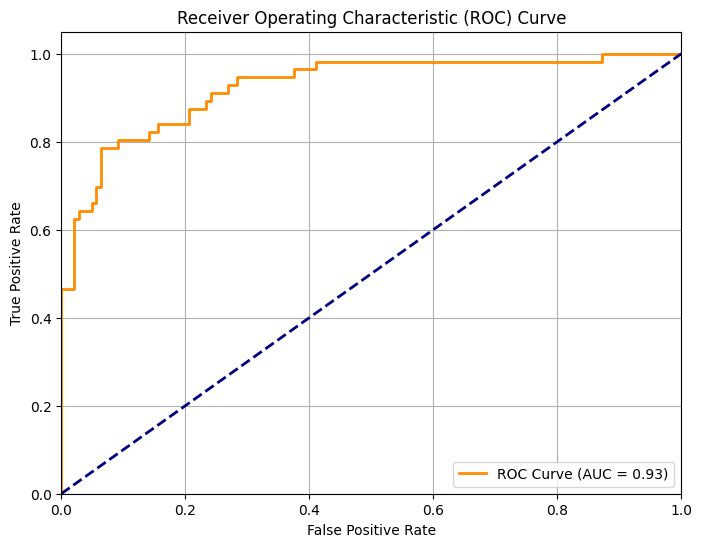

AUC Score: 0.9251519756838906


In [21]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print AUC score
print('AUC Score:', roc_auc)

In [22]:
# Save the trained SVM classifier
joblib.dump(svm_classifier, "skin_cancer_svm_classifier.pkl")

['skin_cancer_svm_classifier.pkl']

In [23]:
import cv2
import numpy as np
import joblib

# Load the saved SVM classifier
svm_classifier = joblib.load("skin_cancer_svm_classifier.pkl")

# Constants
IMAGE_SIZE = (224, 224)

# Function to preprocess and extract HOG features from an image
def preprocess_and_extract_features(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read the image in color
    image = cv2.resize(image, IMAGE_SIZE)  # Resize to desired size
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

# Function to generate segmentation mask (simple threshold-based approach)
def generate_segmentation_mask(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, IMAGE_SIZE)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for skin color in HSV
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)

    # Create a binary mask for skin color
    skin_mask = cv2.inRange(hsv_image, lower_skin, upper_skin)

    return skin_mask

# Path to the single image you want to predict
image_path = "/content/gdrive/MyDrive/cancer-full-dataset/benign/000036.png"

# Preprocess and extract features from the image
image_features = preprocess_and_extract_features(image_path)

# Generate the segmentation mask for the image
segmentation_mask = generate_segmentation_mask(image_path)

# Make a prediction using the SVM classifier
predicted_class = svm_classifier.predict([image_features])[0]

# Map the predicted class index to class names
class_names = ["benign", "malignant"]
predicted_class_name = class_names[predicted_class]

# Display the results
print("Predicted Class:", predicted_class_name)
print("Segmentation Mask Shape:", segmentation_mask.shape)

# You can use the segmentation_mask for further analysis or visualization


Predicted Class: benign
Segmentation Mask Shape: (224, 224)
